In [1]:
import numpy as np
from matplotlib import pyplot as plt

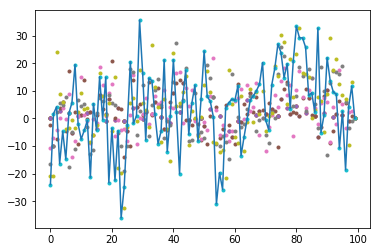

In [2]:
Lx = 100 # Length of field
z = np.zeros(Lx) # Initial topography array
z[:]=np.nan
N = np.sqrt(Lx).astype('int')
A = np.arange(N+1) # Define "amplitude function"
# Array for keeping track of filled points
pts = np.empty(Lx)
pts[:]=np.nan
# Define some initial starting points
pts_start = np.array([0,49,99])
# Assign random numbers to the initial starting points
i=0
for p in pts_start:
    z[int(p)] = A[0]*np.random.normal() # Random number assignment
    pts[int(p)]=int(p) # Keep track of the points that have been filled
    i+=1
    
### Main loop ###
for n in np.arange(N):
    # Isolate the points that have been filled
    pts_filled = pts[~np.isnan(pts)]
    # Define new points half way between the filled points
    pts_new = pts_filled[0:-1]+np.diff(pts_filled)/2
    # Calculate mean topography at new points and add a random number
    i=0
    for p in pts_new:
        pts_around = np.array([pts_filled[i],pts_filled[i+1]]).astype('int')
        mean = np.mean(z[pts_around])
        z[int(p)] = mean+A[n+1]*np.random.normal()
        pts[int(p)]=int(p)
        i+=1
    #print(np.isnan(pts))
    plt.plot(np.arange(0,Lx),z,'.')
plt.plot(z)

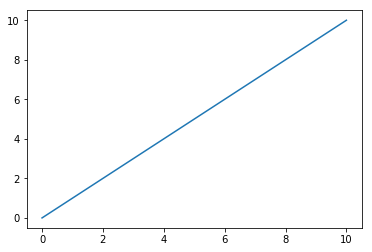

In [3]:
plt.plot(A)

In [105]:
Lx = 100 # Length of field
Ly = 100
z = np.zeros(shape=(Lx,Ly)) # Initial topography array
z[:]=np.nan
N = np.sqrt(np.max([Lx,Ly])).astype('int')
A = np.arange(N+1)-N
pts = np.empty(shape=(Lx,Ly))
pts[:]=np.nan
pts_index = np.empty(shape=(Lx,Ly),dtype=(float,2))
for i  in range(Lx):
    for j in range(Ly):
        pts_index[i,j]=(i,j)

pts_start_x = [0,49,99]
pts_start_y = [0,49,99]

for pi in pts_start_x:
    for pj in pts_start_y:
        z[int(pi),int(pj)]=A[0]*np.random.normal()
        pts[int(pi),int(pj)]=0

for n in range(N):
    pts_filled = pts_index[~np.isnan(pts)]
    pts_new = np.empty(shape=(len(pts_filled)-1,2))
    for i in range(len(pts_filled)-1):
        pi_1 = pts_filled[i,0].astype('int')
        pj_1 = pts_filled[i,1].astype('int')
        pi_2 = pts_filled[i+1,0].astype('int')
        pj_2 = pts_filled[i+1,1].astype('int')

        # NEED TO COME UP WITH A WAY OF DOING THIS COMPREHENSIVELY, CURRENTLY MISSES POINTS BECAUSE ONLY AVERAGES IN SEQUENCE
        pts_new = np.squeeze(pts_filled[i]+np.diff(pts_filled[i:i+2,:],axis=0)/2)
        pi = pts_new[0].astype('int')
        pj = pts_new[1].astype('int')

        z_around = np.array([z[pi_1,pj_1],z[pi_2,pj_2]])
        mean = np.mean(z_around)

        z[pi,pj] = mean+A[n+1]*np.random.normal()
        pts[pi,pj]=0

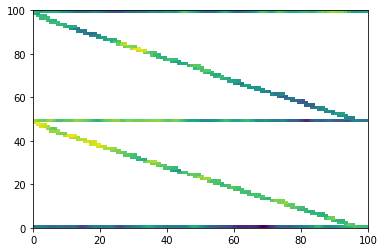

In [106]:
plt.pcolormesh(z)

In [16]:
Lx = 100 # Length of field
Ly = 100
z = np.zeros(shape=(Lx,Ly)) # Initial topography array
z[:]=np.nan
N = np.max([Lx,Ly]).astype('int')
A = -np.arange(N+1)+N
pts = np.empty(shape=(Lx,Ly))
pts[:]=np.nan
pts_index = np.empty(shape=(Lx,Ly),dtype=(float,2))
for i  in range(Lx):
    for j in range(Ly):
        pts_index[i,j]=(i,j)

pts_start_x = [0,49,99]
pts_start_y = [0,49,99]

for pi in pts_start_x:
    for pj in pts_start_y:
        z[int(pi),int(pj)]=A[0]*np.random.normal()
        pts[int(pi),int(pj)]=0
        
for n in range(N):
    while np.where(np.isnan(pts[:]))[0].size>0:
        pts_last = np.array(pts[:])

        pts_filled = pts_index[~np.isnan(pts_last)]
        for i in range(len(pts_filled)-1):
            pi_old = pts_filled[i,0].astype('int')
            pj_old = pts_filled[i,1].astype('int')

            # Search for last and next filled point in each dimension
            # FIRST IN THE X-DIRECTION
            filled_above = ~np.isnan(pts_last[pi_old+1:,pj_old])
            filled_below = ~np.isnan(pts_last[:pi_old,pj_old])
            if np.where(filled_above)[0].size!=0: # Check that there is a filled point above/below
                # Find the index of the next filled point above the current point
                pi_above = np.min(np.where(filled_above))+pi_old+1
                # Get the mid-point between the current point and the point above
                pi = np.mean([pi_old,pi_above]).astype('int')
                if np.isnan(pts[pi,pj_old]): # Make the point hasn't already been filled
                    # Find the mean z between the current point and the point above
                    mean = np.mean(np.array([z[pi_old,pj_old],z[pi_above,pj_old]]))
                    # Add a random number
                    z[pi,pj_old]=mean+A[n+1]*np.random.normal()
                    # Mark that the point has been filled
                    pts[pi,pj_old]=0
            if np.where(filled_below)[0].size!=0:
                pi_below = np.max(np.where(filled_below))
                pi = np.mean([pi_below,pi_old]).astype('int')
                if np.isnan(pts[pi,pj_old]):
                    mean = np.mean(np.array([z[pi_below,pj_old],z[pi_old,pj_old]]))
                    z[pi,pj_old]=mean+A[n+1]*np.random.normal()
                    pts[pi,pj_old]=0
            # NOW IN THE Y-DIRECTION
            filled_above = ~np.isnan(pts_last[pi_old,pj_old+1:])
            filled_below = ~np.isnan(pts_last[pi_old,:pj_old])
            if np.where(filled_above)[0].size!=0:
                pj_above = np.min(np.where(filled_above))+pj_old+1
                pj = np.mean([pj_old,pj_above]).astype('int')
                if np.isnan(pts[pi_old,pj]):
                    mean = np.mean(np.array([z[pi_old,pj_old],z[pi_old,pj_above]]))
                    z[pi_old,pj]=mean+A[n+1]*np.random.normal()
                    pts[pi_old,pj]=0
            if np.where(filled_below)[0].size!=0:
                pj_below = np.max(np.where(filled_below))
                pj = np.mean([pj_below,pj_old]).astype('int')
                if np.isnan(pts[pi_old,pj]):
                    mean = np.mean(np.array([z[pi_old,pj_below],z[pj_old,pj_old]]))
                    z[pi_old,pj]=mean+A[n+1]*np.random.normal()
                    pts[pi_old,pj]=0

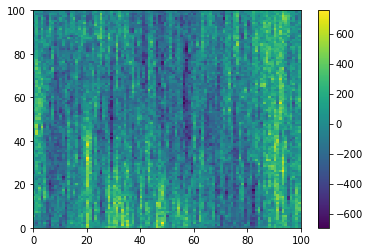

In [17]:
plt.pcolormesh(z)
plt.colorbar()

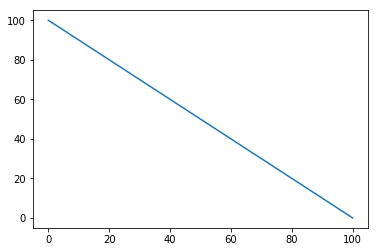

In [18]:
plt.plot(A)